# Transfer Learning

Using an already trained CNN (usu. on the ImageNet dataset) to classify a new dataset that would be too small to train a CNN from scratch.  In this type of learning only the weights of the final fully connected layer are adjusted.

These two major transfer learning scenarios look as follows:

* **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.


* **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


## Imports

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()

## Load Data

In [2]:
# Data sugmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/Images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

## Visualization

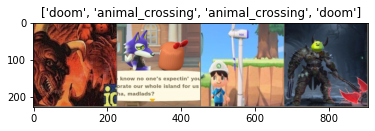

In [4]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
* Schedualing the learning rate
* Saving the best model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions
Function to display predictions for a few images

In [6]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu(). data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning The Convnet

Load a pretrained model and reset the final fully connected layer.

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and Evaluate

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6129 Acc: 0.7131
val Loss: 0.3059 Acc: 0.8634

Epoch 1/24
----------
train Loss: 0.5789 Acc: 0.7514
val Loss: 0.2890 Acc: 0.8634

Epoch 2/24
----------
train Loss: 0.6857 Acc: 0.7242
val Loss: 0.3234 Acc: 0.9130

Epoch 3/24
----------
train Loss: 0.6508 Acc: 0.7528
val Loss: 0.2569 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5153 Acc: 0.7855
val Loss: 0.2653 Acc: 0.9006

Epoch 5/24
----------
train Loss: 0.4754 Acc: 0.8092
val Loss: 0.3969 Acc: 0.8075

Epoch 6/24
----------
train Loss: 0.5480 Acc: 0.7716
val Loss: 0.2590 Acc: 0.9193

Epoch 7/24
----------
train Loss: 0.3373 Acc: 0.8586
val Loss: 0.2548 Acc: 0.9255

Epoch 8/24
----------
train Loss: 0.3477 Acc: 0.8496
val Loss: 0.2441 Acc: 0.9130

Epoch 9/24
----------
train Loss: 0.3309 Acc: 0.8621
val Loss: 0.2697 Acc: 0.9068

Epoch 10/24
----------
train Loss: 0.3688 Acc: 0.8391
val Loss: 0.2498 Acc: 0.9006

Epoch 11/24
----------
train Loss: 0.3563 Acc: 0.8377
val Loss: 0.2499 Acc: 0.9006

Ep

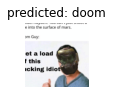

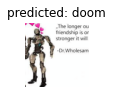

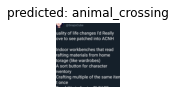

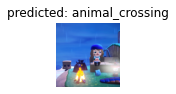

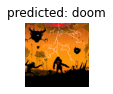

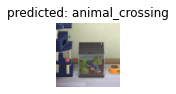

In [9]:
visualize_model(model_ft)

## ConvNet as Fixed Feature Extractor

Here, the network is frozen except for the final layer. Need to set required_grad == False to freeze the parameters so that the gradients are not computed in backwards()

In [10]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have required_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6080 Acc: 0.7214
val Loss: 0.2911 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.6908 Acc: 0.7305
val Loss: 0.4495 Acc: 0.8199

Epoch 2/24
----------
train Loss: 0.5951 Acc: 0.7430
val Loss: 0.2864 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5783 Acc: 0.7681
val Loss: 0.3933 Acc: 0.8571

Epoch 4/24
----------
train Loss: 0.5147 Acc: 0.7779
val Loss: 0.2876 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.6382 Acc: 0.7403
val Loss: 0.3564 Acc: 0.8447

Epoch 6/24
----------
train Loss: 0.5966 Acc: 0.7430
val Loss: 0.2296 Acc: 0.9006

Epoch 7/24
----------
train Loss: 0.4787 Acc: 0.7834
val Loss: 0.2510 Acc: 0.8882

Epoch 8/24
----------
train Loss: 0.4443 Acc: 0.7981
val Loss: 0.2483 Acc: 0.8882

Epoch 9/24
----------
train Loss: 0.5039 Acc: 0.7625
val Loss: 0.2893 Acc: 0.8820

Epoch 10/24
----------
train Loss: 0.4450 Acc: 0.7960
val Loss: 0.2577 Acc: 0.8944

Epoch 11/24
----------
train Loss: 0.4546 Acc: 0.8036
val Loss: 0.2685 Acc: 0.8696

Ep

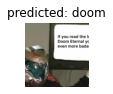

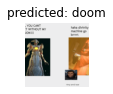

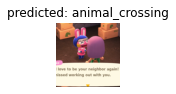

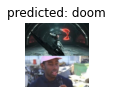

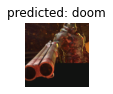

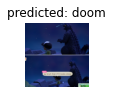

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()